# Data-driven Scheduling and Routing of Vehicles  in Accra

In [8]:
import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt

# silence warnings
import warnings
warnings.filterwarnings("ignore")

<img src="schema.png"></img>

In [2]:
# source files for GTFS data
src_agency = "../data_src/agency.txt"
src_calender = "../data_src/calendar.txt"
src_fare_attributes = "../data_src/fare_attributes.txt"
src_fare_rules = "../data_src/fare_rules.txt"
src_routes = "../data_src/routes.txt"
src_stops = "../data_src/stops.txt"
src_stop_times = "../data_src/stop_times.txt"
src_trips = "../data_src/trips.txt"
src_shapes = "../data_src/shapes.txt"

# Load GTFS data
ag = pd.read_csv(src_agency, encoding='utf-8')
cal = pd.read_csv(src_calender, encoding='utf-8')
fare_attributes = pd.read_csv(src_fare_attributes, encoding='utf-8')
fare_rules = pd.read_csv(src_fare_rules, encoding='utf-8')
routes = pd.read_csv(src_routes, encoding='utf-8')
stops = pd.read_csv(src_stops, encoding='utf-8')
stops = pd.read_csv(src_stops, encoding='utf-8')
stop_times = pd.read_csv(src_stop_times, encoding='utf-8')
trips = pd.read_csv(src_trips, encoding='utf-8')
shapes = pd.read_csv(src_shapes, encoding='utf-8')


# Explore Stops and Terminals

In [ ]:
# Groupby stops and count the number of stop_times for each stop

stop_counts = stop_times.groupby('stop_id').size().reset_index(name='count')
stop_counts
# Merge the stop_counts with the stops DataFrame
stops_with_counts = pd.merge(stops, stop_counts, on='stop_id', how='left')\
                    .sort_values(by='count', ascending=False).reset_index(drop=True)

route_stops = stops_with_counts[stops_with_counts['stop_id'].apply(lambda x: x[0] != 'T')].reset_index(drop=True)

terminals = stops_with_counts[stops_with_counts['stop_id'].apply(lambda x: x[0] == 'T')].reset_index(drop=True)

terminals

,stop_id,stop_name,stop_lat,stop_lon,count
0,T0,Terminal Abeka lapaz,5.607405,-0.247032,112
1,T75,Terminal Kaneshie Mkt Cmplx,5.565072,-0.235921,66
2,T136,Terminal Nima Overhead Station,5.581370,-0.198538,47
3,T251,Terminal Achimota Station,5.620789,-0.225837,46
4,T244,Terminal Accra New Tema Station,5.548629,-0.201709,44
...,...,...,...,...,...
225,T1789,Terminal Accra CMB 2,5.560070,-0.232294,1
226,T2694,Terminal Old Melcom 2,5.587400,-0.226946,1
227,T5559,Terminal Accra UTC Taxi Rank,5.547050,-0.210449,1
228,T5685,Terminal F,5.642330,-0.210306,1


In [4]:
route_stops

,stop_id,stop_name,stop_lat,stop_lon,count
0,S569,Dzorwulu Junction,5.607488,-0.207327,12
1,S914,Korle Bu,5.536127,-0.226771,12
2,S937,Korle Bu,5.536194,-0.226506,12
3,S415,Pokuase Junction,5.687735,-0.281729,11
4,S880,Nyamekye 2,5.602377,-0.258796,10
...,...,...,...,...,...
2330,S2189,UBA,5.611580,-0.198684,1
2331,S455,CPF,5.627490,-0.249401,1
2332,S313,American House,5.649180,-0.150011,1
2333,S1317,Roundabout 185,5.535920,-0.213750,1


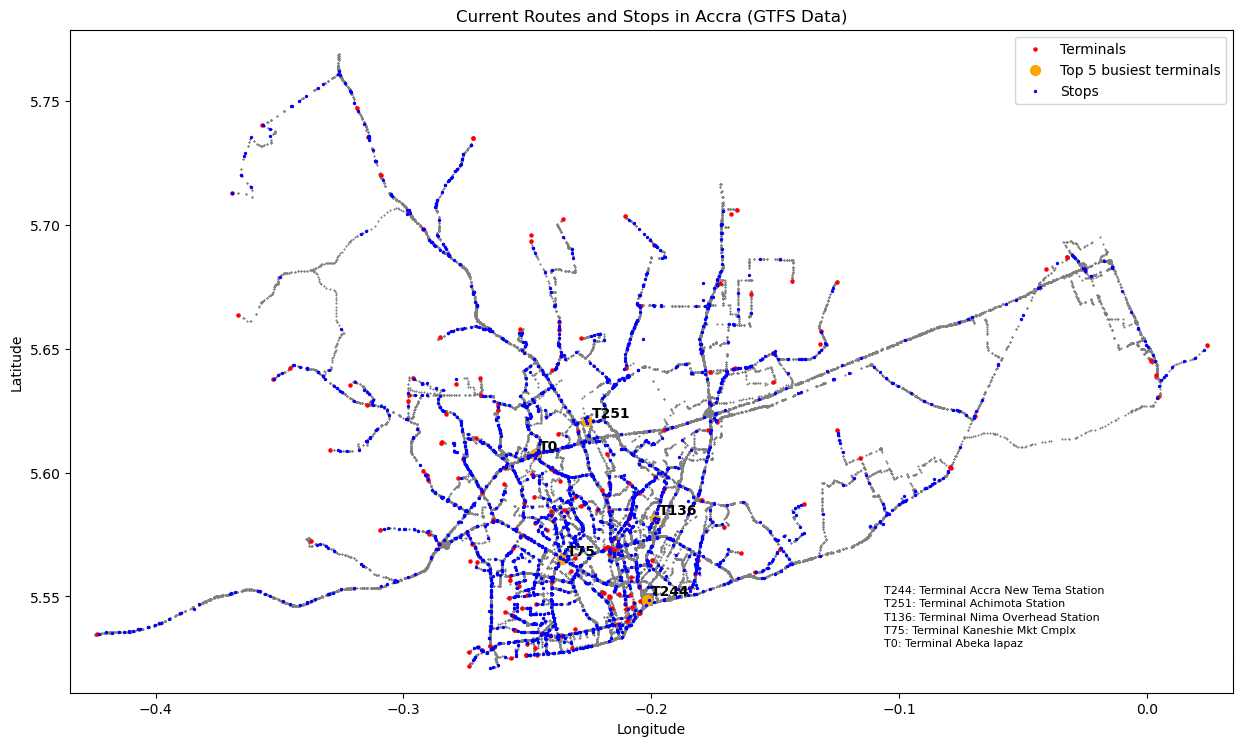

In [4]:

# plot the shapes
# Shapes
shapes_gdf = gpd.GeoDataFrame(shapes, geometry=gpd.points_from_xy(shapes['shape_pt_lon'], shapes['shape_pt_lat']))
shapes_gdf.plot(figsize=(15, 15), marker='*', color='grey', markersize=0.2)

# Terminals
# I need to label Top_5_busy_terminals by their anme (column stop_name)
terminals_gdf = gpd.GeoDataFrame(terminals, geometry=gpd.points_from_xy(terminals['stop_lon'], terminals['stop_lat']))
terminals_gdf.plot(ax=plt.gca(), marker='o', color='red', markersize=5, label='Terminals')

# Label Top 5 busy terminals by their stop_name
Top_5_busy_terminals = terminals.sort_values(by='count', ascending=False).head(5)['stop_id']
top5 = terminals_gdf[terminals_gdf['stop_id'].isin(Top_5_busy_terminals)]
for _, row in top5.iterrows():
    plt.annotate(
        row['stop_id'],
        (row['stop_lon'], row['stop_lat']),
        xytext=(3, 3),
        textcoords='offset points',
        fontsize=10,
        color='black',
        weight='bold'
    )
# Increase the markersize for annotated terminals (Top 5 busy terminals)
top5.plot(ax=plt.gca(), marker='o', color='orange', markersize=50, label='Top 5 busiest terminals')
# draw a box at the bottom right of the graph for Top 5 terminals (explanining sto_id using the stop_name, e.g. T251: ....) 
plt.gca().add_patch(plt.Rectangle((0.9, 0.05), 0.15, 0.15, transform=plt.gca().transAxes, color='white', alpha=0.5, zorder=10))
for _, row in top5.iterrows():
    plt.annotate(
        f"{row['stop_id']}: {row['stop_name']}",
        (0.7, 0.07 + 0.02 * (top5.index.get_loc(row.name))),
        xycoords='axes fraction',
        fontsize=8,
        # color='black',
        # weight='bold'
    )


# Stops
stops_gdf = gpd.GeoDataFrame(route_stops, geometry=gpd.points_from_xy(route_stops['stop_lon'], route_stops['stop_lat']))
stops_gdf.plot(ax=plt.gca(), marker='o', color='blue', markersize=2, label='Stops')
plt.legend()

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(shapes['shape_pt_lon'].min() - 0.01, shapes['shape_pt_lon'].max() + 0.01)
plt.ylim(shapes['shape_pt_lat'].min() - 0.01, shapes['shape_pt_lat'].max() + 0.01)

plt.title('Current Routes and Stops in Accra (GTFS Data)')
plt.show()

# Questions:
- What time does vehicles spend in moving from their origin to their destination terminal? 
- How many stops exist along their routes?
    - How does these stops impact their travel time?
    - Is there any relationship between the number of stops and revenue?
    - Which one offers more revenue? travel time reduction or the number of stops? <b style="color: red">(If the number of stops in a trip provide more revenue drivers may not be willing to be re-routed on a different route, though, it may increase travel time and carborn emissions)</b>

    - <p style="color: blue">How can we predict the number of stops for every trip on a route?</p> <b style="color: red">(Once the vehicle sets off, the next bus stop to stop at is stochastic. This is because in the trotro operation in Ghana, some agencies collect fares after the vehicle is set-off and the passenger's destination becomes known at this point. However this may not be the same for some agencies)</b>
    - <p style="color: blue">What information is required to achieve this?</p> (e.g., road features, days, population along the routes, etc)
    - <p style="color: blue">How useful is the predicted number of stops?</p> (Can guide routing of the vehicles to reduce their travel time)
- What is the current scheduling arrangement adopted by the agencies at the terminals?
    - Is this arrangement efficient?
    - How does it impact vehicle travel time?
    - Does these agencies (at Origin and Destination terminals) collaborate? To what extent do they collaborate?
    - Is scheduling collaboration beneficial in travel time reduction?
    - <p style="color: blue">Is there a better scheduling alternative?</p>
    - <p style="color: blue">How can agency collaboration be integrated into vehicle scheduling to improve travel time?</p>

## Goals

- <b style="color: green">Predict the Number of stops a vehicle makes in an O-D trip</b>
- <b style="color: green">Predict the travel time of vehicles from orgin terminal to destination terminal</b>
- <b style="color: green">Provide Scheduling model to guide agencies at the terminals. This will require the agencies to collaborate. Would need analyses on the extent to which they should collaborate</b>
- <b style="color: green">Provide Real time routing model for the vehicles to reduce their travel time and improve revenue</b>
- <b style="color: green">Design an Intelligent Decision Support System to guide agencies in their collaboration to schedule vehicles efficiently </b>
- <b style="color: green">Integrate the scheduling and the routing (Future)</b>

<table>
    <tr>
        <td><img width="850px" height="530px" src="hackathon_proposed_system.jpg" ></img></td>
        <td><img width="650px" height="550px" src="hackathon_routing.jpg" ></img></td>
    </tr>
</table>


# Rigorous Initial Analysis on the following to answer some of the questions raised above:
- Stop times
- Travel time
- Time spend at the terminal
- Congestion at the terminal
- Routes:
- Stops

In [6]:
stop_times.head()


,trip_id,arrival_time,departure_time,stop_sequence,stop_id
0,002A_1,12:51:38,12:51:38,1,T5622
1,002A_1,13:01:28,13:01:28,2,S5624
2,002A_1,13:02:48,13:02:48,3,S3975
3,002A_1,13:03:43,13:03:43,4,S3974
4,002A_1,13:05:20,13:05:20,5,S5627


In [7]:
routes.sort_values(by='route_id').reset_index(drop=True).head()
# add time spent on each route

,route_id,route_short_name,agency_id,route_long_name,route_type
0,002A,002A,87,37 Lorry Park to Osu Blow Up,3
1,002B,002B,87,Osu Blow Up to 37 Lorry Park,3
2,003A,003A,63,37 Lorry Park to Tse Addo,3
3,003B,003B,63,Tse Addo to 37 Lorry Park,3
4,004A,004A,2,Abeka lapaz to Ashaiman Station,3
